<a href="https://colab.research.google.com/github/olyandrevn/CycleGAN/blob/main/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/olyandrevn/CycleGAN.git

Cloning into 'CycleGAN'...
remote: Enumerating objects: 4045, done.
remote: Counting objects: 100% (1737/1737), done.
remote: Compressing objects: 100% (1679/1679), done.
remote: Total 4045 (delta 90), reused 1696 (delta 52), pack-reused 2308
Receiving objects: 100% (4045/4045), 202.99 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
%cd CycleGAN

/content/CycleGAN


In [ ]:
!pip install -e .

In [4]:
from cyclegan.train.train import create_model_and_optimizer, learning_loop
from cyclegan.train.utils import model_num_params, display_image_pairs

from cyclegan.model.loss import FullDiscriminatorLoss, FullGeneratorLoss
from cyclegan.model.cyclegan import CycleGAN

from cyclegan.dataset.prepare_dataset import prepare_dataset

import torch
import torch.optim as optim

## Load data

In [6]:
target_folder = "data/gzhel2khokhloma"
batch_size = 10

datasets, dataloaders, de_normalize_a, de_normalize_b = prepare_dataset(target_folder, batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
item = next(iter(dataloaders.train_a))
item.shape

torch.Size([10, 3, 128, 128])

## Setup parameters

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

results = []
lr = 2e-3
epochs = 60
# batch_size = 10
lambda_value = 10.0
img_size = 128

step_size_lr = 10
gamma = 0.1

g_iters_per_epoch = 1
d_iters_per_epoch = 1

g_resnet_blocks = 6
d_layers = 3

## Model setup

In [9]:
model_params = {'in_channels': 3,
                'out_channels': 3,
                'n_filters': 64,
                'n_blocks': g_resnet_blocks,
                'n_downsample': 2,
                'n_layers': d_layers}

model, optimizer_d, optimizer_g = create_model_and_optimizer(
    model_class = CycleGAN,
    model_params = model_params,
    lr = lr,
    device = device,
)

scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=step_size_lr, gamma=gamma)
scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=step_size_lr, gamma=gamma)

criterion_d = FullDiscriminatorLoss(is_mse=True, device=device)
criterion_g = FullGeneratorLoss(lambda_value=lambda_value, is_mse=True, device=device)

sum_params, sum_learnable_params = model_num_params(model, verbose_all=False)


In total:
  - 29.594.504 params
  - 29.594.504 learnable params

 . G_AB:
 .   - 7.837.699 params
 .   - 7.837.699 learnable params

 . G_BA:
 .   - 7.837.699 params
 .   - 7.837.699 learnable params

 . D_A:
 .   - 6.959.553 params
 .   - 6.959.553 learnable params

 . D_B:
 .   - 6.959.553 params
 .   - 6.959.553 learnable params


## Run Experiment

In [ ]:
import wandb

config = {
    "lr": lr,
    "epochs": epochs,
    "g_iters_per_epoch": g_iters_per_epoch,
    "d_iters_per_epoch": d_iters_per_epoch,
    "batch_size":  batch_size,
    "lambda_value": lambda_value,
    "g_resnet_blocks": g_resnet_blocks,
    "d_layers": d_layers,
    "img_size": img_size,
    "step_size_lr": step_size_lr
}
model_name = "cycle_gan"

wandb.init(project='cyclegan', entity='cyclegan-gzhel-to-khokhloma', name=model_name, config=config)

In [ ]:
%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = g_iters_per_epoch,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = d_iters_per_epoch,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = epochs,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    chkp_folder = "./chkp",
    model_name = "cycle_gan",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
    # is_wandb=True
)

wandb.finish()

## Load model from checkpoint

In [10]:
!gdown 1SVqnSiRnF99GAXi5o38jUh1LLNWiHQ8K

Downloading...
From (original): https://drive.google.com/uc?id=1SVqnSiRnF99GAXi5o38jUh1LLNWiHQ8K
From (redirected): https://drive.google.com/uc?id=1SVqnSiRnF99GAXi5o38jUh1LLNWiHQ8K&confirm=t&uuid=4454ec80-f280-4118-b1e7-62b32362ea62
To: /content/CycleGAN/cgan_model#bs10#g6#d3#lr3.pt
100% 118M/118M [00:02<00:00, 55.6MB/s]


In [11]:
model_path = 'cgan_model#bs10#g6#d3#lr3.pt'

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Visualize results

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


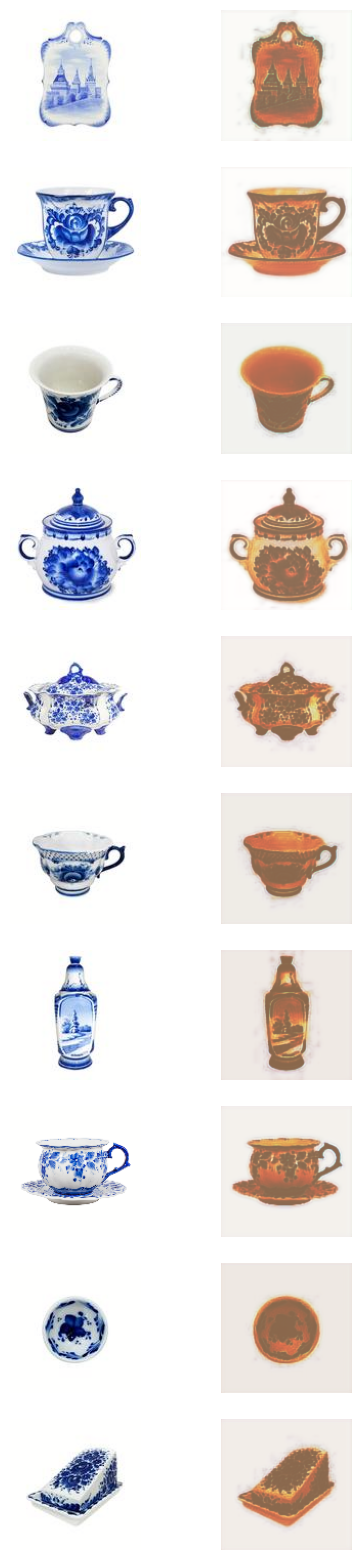

In [12]:
display_image_pairs(datasets, model, 10, de_normalize_a, de_normalize_b, device=device, dataset_type='A')

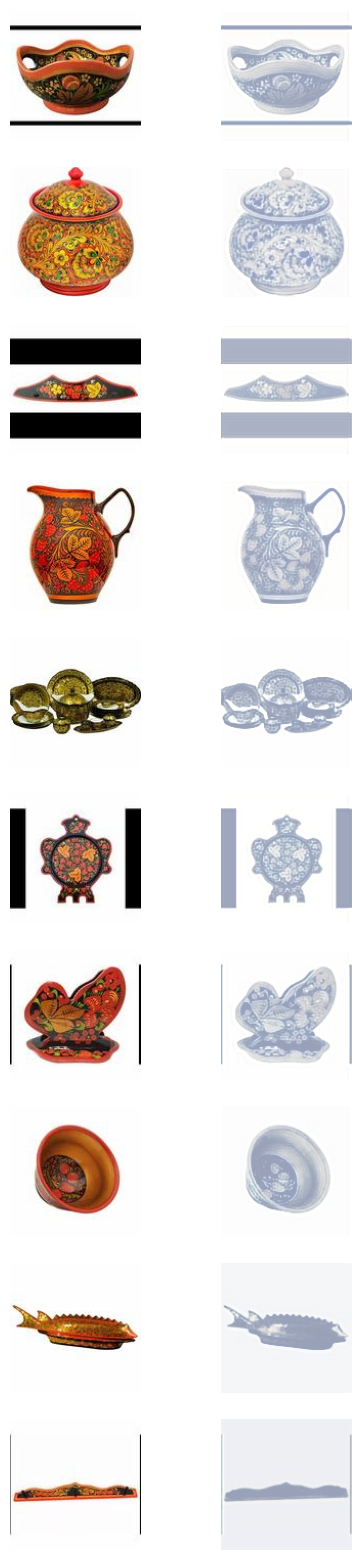

In [13]:
display_image_pairs(datasets, model, 10, de_normalize_a, de_normalize_b, device=device, dataset_type='B')